In [1]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt

## Load data

In [2]:
train = pd.read_json('data/music_reviews_train.json', lines=True)
dev = pd.read_json('data/music_reviews_dev.json', lines=True)
test = pd.read_json('data/music_reviews_test_masked.json', lines=True)

train = train[['reviewText', 'sentiment']]
dev = dev[['reviewText', 'sentiment']]
test = test[['reviewText', 'sentiment']]

train.replace(np.nan, '', regex=True, inplace=True)
dev.replace(np.nan, '', regex=True, inplace=True)
test.replace(np.nan, '', regex=True, inplace=True)

In [3]:
#X_train, y_train = train['reviewText'], train['sentiment']
#X_train = X_train.replace(np.nan, '', regex = True)
#X_dev, y_dev = dev['reviewText'], dev['sentiment']
#X_dev = X_dev.replace(np.nan, '', regex = True)

### Data Exploration

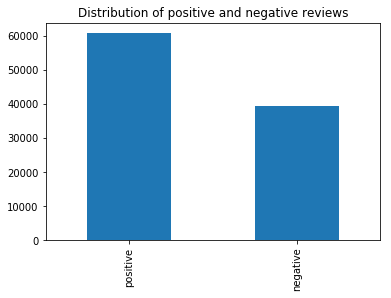

In [4]:
train['sentiment'].value_counts().plot(kind='bar')

plt.title('Distribution of positive and negative reviews')    
plt.show()

In [5]:
train.describe()

,reviewText,sentiment
count,100000,100000
unique,88519,2
top,Great song,positive
freq,305,60783


In [6]:
train.groupby('sentiment').describe()

reviewText                        
               count unique         top freq
sentiment                                   
negative       39217  35705          ok   62
positive       60783  52928  Great song  304

### Balancing dataset

Removing random positive cases untill dataset is even

In [90]:
# Shuffling
train = train.sample(frac=1).reset_index(drop=True)

pos = train.loc[train["sentiment"] == "positive"]
neg = train.loc[train["sentiment"] == "negative"]

pos = pos.iloc[:len(neg)]
train = pd.concat([pos, neg])

train = train.sample(frac=1).reset_index(drop=True)
train.head(5)

,reviewText,sentiment
0,"I've listened to the audio samples from ""Good ...",negative
1,In a former life I would have told you LP was ...,negative
2,I bought this album because i'm always looking...,negative
3,Just got around to playing this and half the s...,negative
4,Great album!,positive


### Data preprocessing

Remove punctuation and stopwords

In [64]:
import string
from nltk.corpus import stopwords

def preprocess_text(text):
    puncs = string.punctuation
    stops = stopwords.words('english')
    no_punc = [token for token in text if token not in puncs]                               #remove punctuations
    no_punc = ''.join(no_punc)
    no_stops = [word.lower() for word in no_punc.split() if word.lower() not in stops]      #remove stopwords
    
    return ' '.join(no_stops)

In [65]:
# View how the text is cleaned
train['reviewText'].head(5).apply(preprocess_text)

0                            got playlist make cup tea
1    instrumental pink floyd album sounds like wond...
2    wth rerecorded crap says album version doesnt ...
3    use huge ntwicm fan 4 5 6 7 8 9 10 11 1213 14 ...
4    years contemporary christian artists tried emu...
Name: reviewText, dtype: object

In [66]:
train_clean = train['reviewText'].apply(preprocess_text).tolist()
dev_clean = dev['reviewText'].apply(preprocess_text).tolist()
test_clean = test['reviewText'].apply(preprocess_text).tolist()

### Bag of Words (BOW)

We have to convert each reviewText into a vector through a BOW representation.

Each will the dimension as the unique words in the reviews. **CountVectorizer** will convert the reviews into a matrix of word counts. The columns are a word (entire vocab) and the rows are each review, and 1 is present if that word is present in the reviewText.

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
bow_transformer = CountVectorizer(ngram_range=(1,2)).fit(train_clean)
print(f'Vocab size: {len(bow_transformer.vocabulary_)}')

Vocab size: 1116849


In [79]:
# Apply transformation to data
train_bow = bow_transformer.transform(train_clean)
dev_bow = bow_transformer.transform(dev_clean)
test_bow = bow_transformer.transform(test_clean)

In [80]:
print(f'Shape of sparse matrix: {train_bow.shape}')

Shape of sparse matrix: (78434, 1116849)


### Weights

**TF-IDF**

Calculate the number of times a word appears in a sentence divided by the total number of words in the sentence.

In [81]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(train_bow)

In [82]:
train_tfidf = tfidf_transformer.transform(train_bow)
dev_tfidf = tfidf_transformer.transform(dev_bow)
test_tfidf = tfidf_transformer.transform(test_bow)
print(train_tfidf.shape)

(78434, 1116849)


In [83]:
train_tfidf[1,:]

<1x1116849 sparse matrix of type '<class 'numpy.float64'>'
	with 109 stored elements in Compressed Sparse Row format>

### Model training and evaluation

In [84]:
# Train a NaiveBayes model on the traning vectorized reviews

from sklearn.naive_bayes import MultinomialNB
NaiveBayes = MultinomialNB().fit(train_tfidf, train['sentiment'])

In [85]:
# Predict the sentences in the dev set

predictions = NaiveBayes.predict(dev_tfidf)
from sklearn.metrics import accuracy_score
accuracy_score(predictions, dev['sentiment'])

0.8548

### Output predictions on test to csv

In [86]:
test_pred = NaiveBayes.predict(test_tfidf)

In [87]:
label2idx = {'negative': 0, 'positive':1}
#labels to numeric
test_pred_numeric = list(map(label2idx.get, test_pred))

In [88]:
#kaggle_df = pd.DataFrame(test_pred_numeric, columns=['prediction'])
#kaggle_df.to_csv('test_predictions.csv', index_label='id')